In [1]:
import sys
sys.path.append("/home/vivekm/captum/")

In [2]:
import torch
import torchvision
from torchvision import transforms
import torchvision.models as models

In [3]:
%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from captum.attr import IntegratedGradientsExp, IntegratedGradients
from captum.attr import visualization as viz

In [4]:
model_conv = torchvision.models.resnet18(pretrained='imagenet')
model_conv.eval()
model_conv_cuda = model_conv.cuda()

In [5]:
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 ])
mean=torch.tensor([0.485, 0.456, 0.406]).reshape(1,3,1,1)                #[6]
std=torch.tensor([0.229, 0.224, 0.225]).reshape(1,3,1,1)                #[7]


In [6]:
imagenet_data = torchvision.datasets.ImageNet('/home/vivekm/imagenet/',split="val",transform=transform)
data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=1,shuffle=True)

In [7]:
def split_ig(model, inp, target, baseline=None, ratio=0.5):
    final_out = model(inp)[:,target].item()
    if baseline is None:
        baseline = torch.zeros_like(inp)
    baseline_out = model(baseline)[:, target].item()
    threshold = baseline_out + ratio*(final_out - baseline_out)
    ig_exp = IntegratedGradientsExp(model_conv_cuda)
    grads, outputs, steps, scaled_features = ig_exp.attribute(inp, target=target, method="riemann_right", baselines=baseline,n_steps=200)
    threshold_index = None
    for i in range(len(outputs)):
        if outputs[i] > threshold:
            threshold_index = i
            break
    print(threshold_index)
    steps = steps.reshape((len(steps),) + (1,)*(len(inp.shape) - 1)).to(inp.device)
    left_ig = grads[0][:threshold_index]*steps[:threshold_index]*(inp-baseline)
    right_ig = grads[0][threshold_index:]*steps[threshold_index:]*(inp-baseline)
    return left_ig.sum(dim=0,keepdim=True), right_ig.sum(dim=0,keepdim=True), threshold_index

In [8]:
saved_image = None
saved_label = None
rel_mag = []
rel_sum = []
thresholds = []
for id, batch in enumerate(data_loader):
    saved_image, saved_label = batch
    normalized_image = ((saved_image - mean) / std).cuda()
    #normalized_baseline = ((torch.zeros_like(saved_image) - mean) / std).cuda()
    if not (model_conv_cuda(normalized_image).topk(1).indices.cpu() == saved_label).item():
        continue
    left_ig, right_ig, threshold = split_ig(model_conv_cuda, normalized_image, target=saved_label.item(), ratio=0.90)
    rel_mag.append((torch.sum(right_ig ** 2) / torch.sum(left_ig ** 2)).item() ** 0.5)
    rel_sum.append((torch.sum(right_ig) / torch.sum(left_ig)).item())
    thresholds.append(threshold)
    if id > 100:
        break

132
106
77
77
88
137
79
164
83
45
98
114
124
130
100
34
134
82
116
107
150
71
126
99
37
156
72
133
54
113
77
57
17
110
173
94
82
145
126
28
122
124
81
127
7
138
78
88
64
170
63
102
75
114
28
149
70
65
94
43
50
19
43
109
64
52
60
63
138
52
13
28
101


In [9]:
sum(thresholds) / (200*len(thresholds))

0.448013698630137

In [10]:
sum(rel_mag) / len(rel_mag)

1.7934539001627483

In [11]:
sum([1 if elem > 4 else 0 for elem in rel_mag]) / len(rel_mag)

0.0821917808219178

(array([17., 15., 10., 10.,  7.,  3.,  3.,  1.,  0.,  1.,  1.,  1.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.18551054,  0.55282597,  0.92014139,  1.28745681,  1.65477224,
         2.02208766,  2.38940309,  2.75671851,  3.12403394,  3.49134936,
         3.85866479,  4.22598021,  4.59329563,  4.96061106,  5.32792648,
         5.69524191,  6.06255733,  6.42987276,  6.79718818,  7.1645036 ,
         7.53181903,  7.89913445,  8.26644988,  8.6337653 ,  9.00108073,
         9.36839615,  9.73571158, 10.103027  , 10.47034242, 10.83765785,
        11.20497327, 11.5722887 , 11.93960412, 12.30691955, 12.67423497,
        13.04155039, 13.40886582, 13.77618124, 14.14349667, 14.51081209,
        14.87812752, 15.24544294, 15.61275836, 15.98007379, 16.34738921,
        16.71470464, 17.08202006, 17.44933549, 17.81665091,

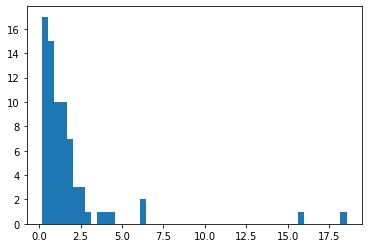

In [12]:
plt.hist(rel_mag,bins=50)

# Analyze Single Image

In [27]:
saved_image = None
saved_label = None

# Obtain random image from data loader.
for id, batch in enumerate(data_loader):
    saved_image, saved_label = batch
    break

In [28]:
normalized_image = ((saved_image - mean) / std).cuda()
# baseline = torch.randn_like(normalized_image)


In [29]:
left_ig, right_ig, threshold = split_ig(model_conv_cuda, normalized_image, target=saved_label.item(), ratio=0.90)# baseline=baseline)
print(torch.sum(left_ig))
print(torch.sum(right_ig))
print(torch.sum(left_ig ** 2))
print(torch.sum(right_ig ** 2))

53
tensor(16.5853, device='cuda:0')
tensor(1.8453, device='cuda:0')
tensor(13.4031, device='cuda:0')
tensor(48.0132, device='cuda:0')


In [30]:
# Check if model top output is correct
(model_conv_cuda(normalized_image).topk(1).indices.cpu() == saved_label).item()

True

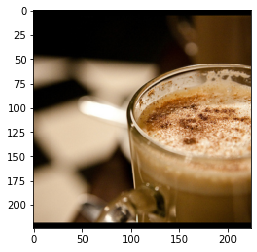

In [31]:
plt.imshow(saved_image[0].permute(1,2,0))

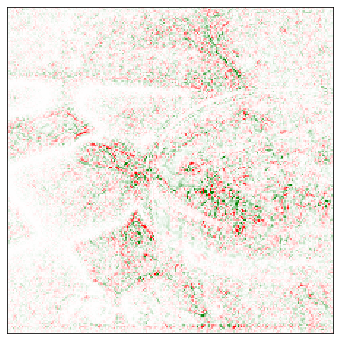

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43e123e910>)

In [32]:
viz.visualize_image_attr(left_ig[0].cpu().permute(1,2,0).numpy(),sign="all")#original_image=saved_image[0].permute(1,2,0).numpy(),method="blended_heat_map")
#plt.imshow(normalized_image[0].cpu().permute(1,2,0))

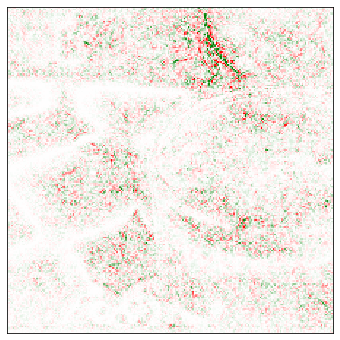

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43e1210e50>)

In [33]:
viz.visualize_image_attr(right_ig[0].cpu().permute(1,2,0).numpy(),sign="all")#original_image=saved_image[0].permute(1,2,0).numpy(),method="blended_heat_map")


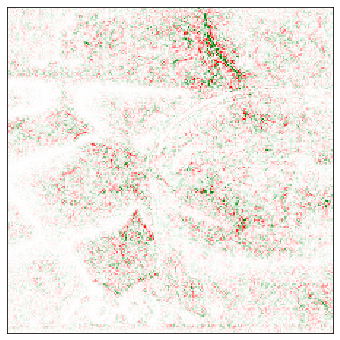

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43e1150b90>)

In [34]:
viz.visualize_image_attr((left_ig + right_ig)[0].cpu().permute(1,2,0).numpy(),sign="all")#original_image=saved_image[0].permute(1,2,0).numpy(),method="blended_heat_map")


In [37]:
torch.abs(left_ig).sum()

tensor(856.0381, device='cuda:0')

In [38]:
ig_exp = IntegratedGradientsExp(model_conv_cuda)
grads, outputs, steps, scaled_features = ig_exp.attribute(normalized_image, target=saved_label.item(), method="riemann_right",n_steps=200) #, baselines=baseline)

In [39]:
ig_exp = grads[0]*steps.reshape(200,1,1,1).cuda()*normalized_image

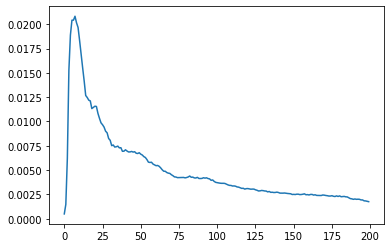

In [40]:
plt.plot((ig_exp ** 2).sum(dim=(1,2,3)).cpu())

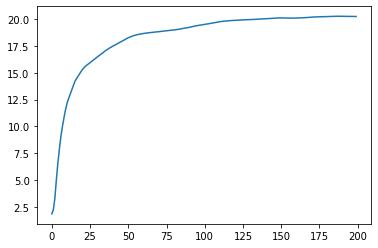

In [41]:
plt.plot(outputs.detach().cpu())

In [42]:
saved_label

tensor([969])